In [1]:
from __future__ import print_function, division
import torch
import torch.nn as nn
import torch_optimizer as optim
import torch.utils.data as data
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import math
import shutil

#Advanced Pytorchから
import glob
import os.path as osp
import random
import json
from PIL import Image
from tqdm import tqdm
%matplotlib inline
import cv2

plt.ion()   # interactive mode
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Set random seem for reproducibility
manualSeed = 1234
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.cuda.manual_seed(manualSeed)

torch.torch.backends.cudnn.benchmark = True
torch.torch.backends.cudnn.enabled = True


'''
新しいフォルダを作成し、データセットをtrainとvalに振り分けるスクリプト

train -----n000001 
        |--n000002 
        |　…
        |　…
        |--n000009 

    ↓

train2------train-----n000001 
         |         |--n000002 
         |         |-- …
         |         |--n000009 
         |
         |---val------n000001 
                   |--n000002 
                   | 　…
                   |--n000009 
'''                        

Random Seed:  1234


'\n新しいフォルダを作成し、データセットをtrainとvalに振り分けるスクリプト\n\ntrain -----n000001 \n        |--n000002 \n        |\u3000…\n        |\u3000…\n        |--n000009 \n\n    ↓\n\ntrain2------train-----n000001 \n         |         |--n000002 \n         |         |-- …\n         |         |--n000009 \n         |\n         |---val------n000001 \n                   |--n000002 \n                   | \u3000…\n                   |--n000009 \n'

# モジュール群

In [3]:
#datasetの場所と、weightsの保存先を指定
data_dir = 'C:\\Datasets\\VGGface2\\train_8631'
weights_dir = 'C:\\Datasets\\weights\\VGGFace2_8631_EfficientNet_adamod.pth'

number of classes: 8631
training data set_total：2510069
validating data set_total：631821


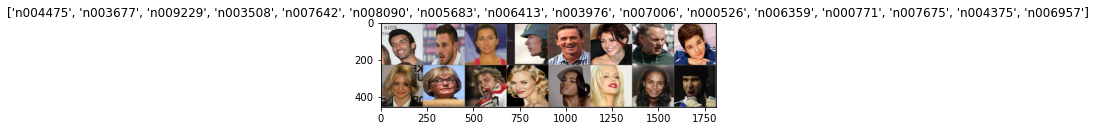

In [4]:
# 入力画像の前処理をするクラス
# 訓練時と推論時で処理が異なる

"""
    画像の前処理クラス。訓練時、検証時で異なる動作をする。
    画像のサイズをリサイズし、色を標準化する。
    訓練時はRandomResizedCropとRandomHorizontalFlipでデータオーギュメンテーションする。


    Attributes
    ----------
    resize : int
        リサイズ先の画像の大きさ。
    mean : (R, G, B)
        各色チャネルの平均値。
    std : (R, G, B)
        各色チャネルの標準偏差。
"""

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224, scale=(0.75,1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.RandomResizedCrop(224, scale=(1.0,1.0)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}



n_samples = len(data_dir)

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=16,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")



print('number of classes: ' +str(len(class_names)))
'''
print(class_names)
k=0
for i in class_names:
    print(class_names[k]+"_train:"+str(len(os.listdir(path= data_dir + '\\train\\' +class_names[k]))))
    k+=1
k=0
for i in class_names:
    print(class_names[k]+"_val:"+str(len(os.listdir(path= data_dir + '\\val\\' +class_names[k]))))
    k+=1
'''
print("training data set_total："+ str(len(image_datasets['train'])))
print("validating data set_total："+str(len(image_datasets['val'])))


#少数の画像を可視化
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])


#Defining early stopping class
import numpy as np
import torch

class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), 'checkpoint.pt')
        self.val_loss_min = val_loss


#Train models
def train_model(model, criterion, optimizer, patience, num_epochs, weights_dir):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # to track the training loss as the model trains
    train_loss = []
    # to track the validation loss as the model trains
    valid_loss = []


    # initialize the early_stopping object
    early_stopping = EarlyStopping(patience=patience, verbose=True)

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase] 
            
            # record train_loss and valid_loss
            if phase == 'train':
                train_loss.append(epoch_loss)
                print('epoch:{}'.format(epoch))
            if phase == 'val':
                valid_loss.append(epoch_loss)
            #print(train_loss)
            #print(valid_loss)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            #save weights in every epochs
            PATH = weights_dir 
            torch.save(model_ft.state_dict(), PATH)


            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
      
      # early_stopping needs the validation loss to check if it has decresed, 
      # and if it has, it will make a checkpoint of the current model
        if phase == 'val':    
            early_stopping(epoch_loss, model)
                
            if early_stopping.early_stop:
                print("Early stopping")
                break
        print()


    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    
    # save model weights
    PATH = weights_dir +'_best'
    torch.save(model_ft.state_dict(), PATH)


    return model, train_loss, valid_loss


#Visualize model
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)



# Convnetの調整


In [5]:
!pip install efficientnet_pytorch
from efficientnet_pytorch import EfficientNet 

model_ft = EfficientNet.from_pretrained('efficientnet-b4')
num_ftrs = model_ft._fc.in_features
model_ft._fc = nn.Linear(num_ftrs, len(class_names))
#GPU使用
model_ft = model_ft.to(device)

#損失関数を定義
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
#https://blog.knjcode.com/adabound-memo/
#https://pypi.org/project/torch-optimizer/
optimizer_ft = optim.AdaBound(
    model_ft.parameters(),
    lr= 1e-3,
    betas= (0.9, 0.999),
    final_lr = 0.1,
    gamma=1e-3,
    eps= 1e-8,
    weight_decay=0,
    amsbound=False,
)

Loaded pretrained weights for efficientnet-b4


In [7]:
print(device)

cuda:0


In [4]:
#ネットワークの確認
print(model_ft)

from torchsummary import summary
model_ft = model_ft.to(device)
summary(model_ft, (3,224,224))

m2d-254          [-1, 672, 14, 14]           1,344
MemoryEfficientSwish-255          [-1, 672, 14, 14]               0
       ZeroPad2d-256          [-1, 672, 16, 16]               0
Conv2dStaticSamePadding-257          [-1, 672, 14, 14]           6,048
     BatchNorm2d-258          [-1, 672, 14, 14]           1,344
MemoryEfficientSwish-259          [-1, 672, 14, 14]               0
        Identity-260            [-1, 672, 1, 1]               0
Conv2dStaticSamePadding-261             [-1, 28, 1, 1]          18,844
MemoryEfficientSwish-262             [-1, 28, 1, 1]               0
        Identity-263             [-1, 28, 1, 1]               0
Conv2dStaticSamePadding-264            [-1, 672, 1, 1]          19,488
        Identity-265          [-1, 672, 14, 14]               0
Conv2dStaticSamePadding-266          [-1, 112, 14, 14]          75,264
     BatchNorm2d-267          [-1, 112, 14, 14]             224
     MBConvBlock-268          [-1, 112, 14, 14]               0
        Ident

In [14]:
model_ft, train_loss, valid_loss = train_model(model_ft, criterion, optimizer_ft,  patience=20, num_epochs=100, weights_dir=weights_dir)


Epoch 0/9
----------
epoch:0
train Loss: 0.6203 Acc: 0.8054
val Loss: 0.4972 Acc: 0.8470
Validation loss decreased (inf --> 0.497159).  Saving model ...

Epoch 1/9
----------
epoch:1
train Loss: 0.1448 Acc: 0.9550
val Loss: 0.2848 Acc: 0.9116
Validation loss decreased (0.497159 --> 0.284826).  Saving model ...

Epoch 2/9
----------
epoch:2
train Loss: 0.0930 Acc: 0.9680
val Loss: 0.0685 Acc: 0.9763
Validation loss decreased (0.284826 --> 0.068460).  Saving model ...

Epoch 3/9
----------
epoch:3
train Loss: 0.0403 Acc: 0.9864
val Loss: 0.0808 Acc: 0.9677
EarlyStopping counter: 1 out of 20

Epoch 4/9
----------
epoch:4
train Loss: 0.0227 Acc: 0.9930
val Loss: 0.1143 Acc: 0.9655
EarlyStopping counter: 2 out of 20

Epoch 5/9
----------
epoch:5
train Loss: 0.0320 Acc: 0.9908
val Loss: 0.0821 Acc: 0.9720
EarlyStopping counter: 3 out of 20

Epoch 6/9
----------
epoch:6
train Loss: 0.0189 Acc: 0.9935
val Loss: 0.0934 Acc: 0.9763
EarlyStopping counter: 4 out of 20

Epoch 7/9
----------
epoch:7

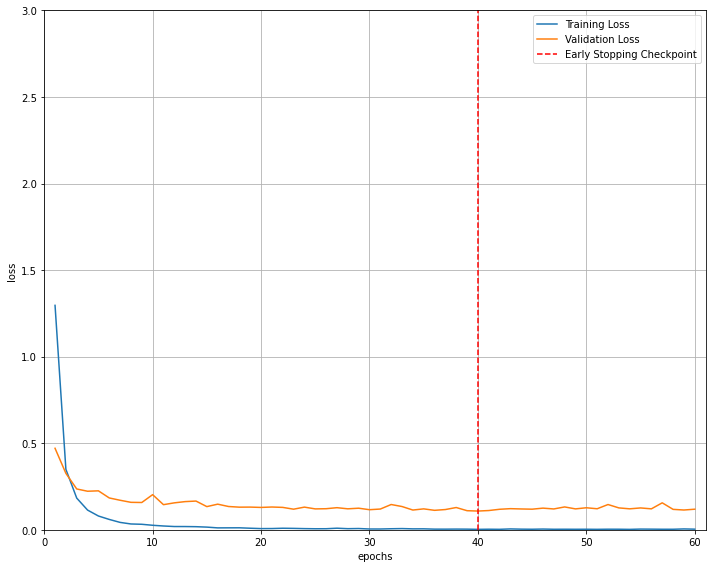

In [6]:
# visualize the loss as the network trained
fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(train_loss)+1),train_loss, label='Training Loss')
plt.plot(range(1,len(valid_loss)+1),valid_loss,label='Validation Loss')

# find position of lowest validation loss
minposs = valid_loss.index(min(valid_loss))+1 
plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

plt.xlabel('epochs')
plt.ylabel('loss')
plt.ylim(0, 3.0) # consistent scale
plt.xlim(0, len(train_loss)+1) # consistent ++++++++scale
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
fig.savefig('loss_plot.png', bbox_inches='tight')

In [ ]:
#正答率の確認
class_correct = list(0. for i in range(len(class_names)))
class_total = list(0. for i in range(len(class_names)))
with torch.no_grad():
    for data in dataloaders['val']:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model_ft(inputs)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(8):
    print('Accuracy of %5s : %2d %%' % (
        class_names[i], 100 * class_correct[i] / class_total[i]))

#ネットワークの読み込み

In [6]:
#ネットワークの読み込み
PATH = weights_dir 
model_ft.load_state_dict(torch.load(PATH))

<All keys matched successfully>